In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

### Load metadata

In [122]:
metadata = pd.read_csv("../../metadata.csv", sep=";")

### Load features and labels

In [142]:
X = pd.read_csv("../../taxonomy/species_data.csv", sep=";").set_index("Sample", drop=True)
# X = X.drop("Gorilla gorilla", axis=1)
# X = X.drop("Homo sapiens", axis=1)

y = pd.read_csv("../../labels.csv", sep=";").set_index("Sample", drop=True)

X = X.loc[metadata[metadata["BioProject"] == "PRJNA904924"]["Run"]]
y = y.loc[metadata[metadata["BioProject"] == "PRJNA904924"]["Run"]]["Label"]

In [143]:
X.shape[0] == y.shape[0]

True

In [144]:
X

,Gorilla gorilla,Saccharomyces cerevisiae,Homo sapiens,Chryseobacterium sp. LAM-KRS1,Pongo abelii,Mangifera indica,Cyprinus carpio,Hylobates moloch,Pipra filicauda,Pan troglodytes,...,Methylonatrum kenyense,Candidatus Nardonella dryophthoridicola,Wohlfahrtiimonas larvae,Buchananvirus Sa179lw,Halospina denitrificans,Dehalogenimonas alkenigignens,Swiduovirus swi2,Shuimuvirus IME207,Akiravirus akira,Pseudohongiella spirulinae
Sample,,,,,,,,,,,,,,,,,,,,,
SRR22402286,135,0,31152,0,0,0,0,0,0,75,...,0,0,0,0,0,0,0,0,0,0
SRR22402358,0,0,1676,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR22402336,519,0,128517,0,0,0,0,0,0,326,...,0,0,0,0,0,0,0,0,0,0
SRR22402380,247,97,62133,0,0,0,0,0,0,170,...,0,0,0,0,0,0,0,0,0,0
SRR22402315,0,0,420,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR22402268,250,1552,60087,0,86,0,0,25,0,158,...,0,0,0,0,0,0,0,0,0,0
SRR22402267,0,102,18447,0,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR22402325,612,0,143507,0,180,0,0,0,0,355,...,0,0,0,0,0,0,0,0,0,0


### Split the data into train and test

In [138]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Grid Search for PCA and Random Forest Classifier

In [127]:
# Define the Pipeline
pipeline = Pipeline([
    ('variance_filter', VarianceThreshold()), # Step 0: filter out variables with variance < threshold
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('min_max_scaler', MinMaxScaler()),  # Step 2: min-max scaling
    ('pca', PCA()),  # Step 3: PCA
    ('rf', RandomForestClassifier(random_state=42))  # Step 4: Random Forest
])

Accuracy: 0.4883720930232558


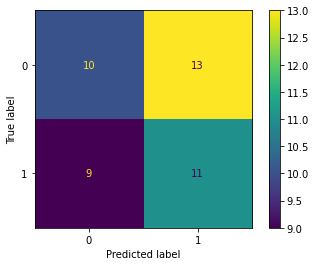

{'pca__n_components': 50,
 'rf__criterion': 'gini',
 'rf__max_depth': 50,
 'rf__max_features': 'log2',
 'rf__n_estimators': 200,
 'variance_filter__threshold': 0.1}

In [120]:
# Define the parameter grid for grid search
param_grid = {
    'variance_filter__threshold': [0.1], # grid search value for variance filter threshold
    'pca__n_components': [30, 40, 50],  # Step 3:grid search number of components
    'rf__n_estimators': [200, 250, 300],  # Step 4: grid search for n_estimators
    'rf__max_depth': [50, 100, 300, None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_

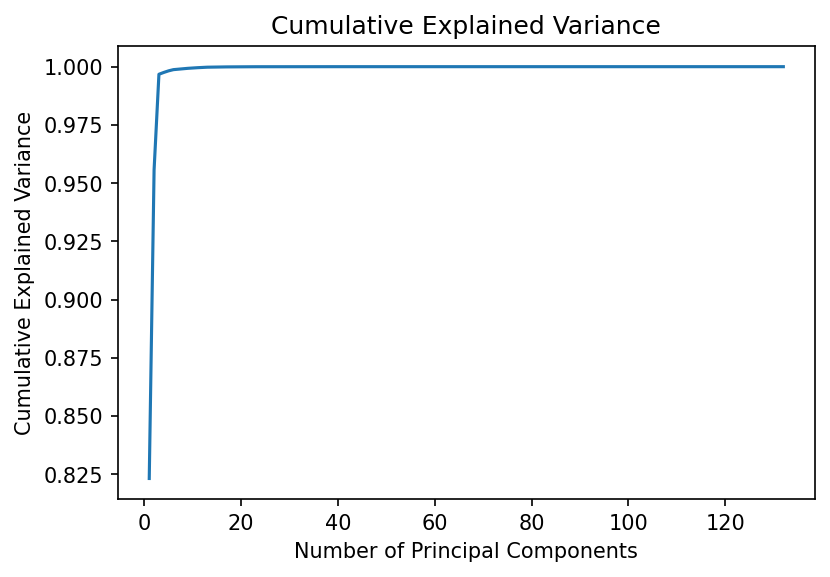

In [139]:
# Perform PCA
pca = PCA()
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Grid Search for ANOVA and random forest 

In [80]:
# Define the Pipeline
pipeline = Pipeline([
    ('variance_filter', VarianceThreshold()),
    ('feature_selection', SelectKBest(f_classif)),  # Step 1: feature selection using ANOVA F-value
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 2: log transformation
    ('min_max_scaler', MinMaxScaler()),  # Step 3: min-max scaling
    ('rf', RandomForestClassifier())  # Step 4: Random Forest with default hyperparameters
])

# Define the parameter grid for grid search
param_grid = {
    'variance_filter__threshold': [0.0, 0.1, 0.2],
    'feature_selection__k': [5, 10, 15],  # Step 1: select k features
    'rf__n_estimators': [100, 200, 300],  # Step 4: grid search for n_estimators
    'rf__max_depth': [5, 10, 15]  # Step 4: grid search for max_depth
}

# Define the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.625
